### Build Satellite

In [1]:
from satellite import Satellite

# Create a Satellite instance
# can customize the spacecraft body-frame vectors and reaction wheel limitations
CASTOR = Satellite()
print(CASTOR)

Calculating slew durations based on spacecraft's reaction wheel limitations...
runtime: 01m 14.553s
<Satellite object: max_wheel_momentum=18 N·m·s, max_wheel_torque=0.1 N·m>


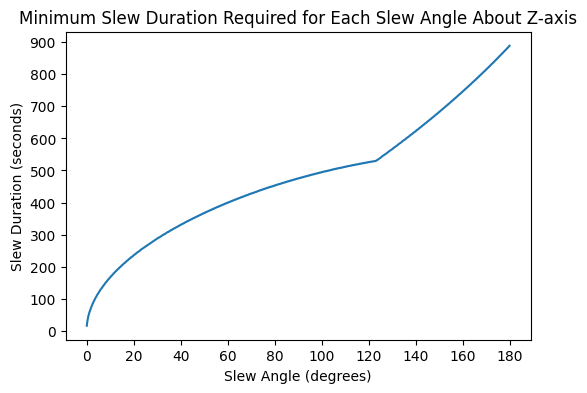

In [2]:
import matplotlib.pyplot as plt

# Visualize the spacecraft's slew angle vs. slew time
plt.figure(figsize=(6, 4))
plt.plot(CASTOR.slew_angle_data, CASTOR.slew_time_data)
plt.xticks(range(0, 181, 20))
plt.yticks(range(0, 1000, 100))
plt.xlabel('Slew Angle (degrees)')
plt.ylabel('Slew Duration (seconds)')
plt.title('Minimum Slew Duration Required for Each Slew Angle About Z-axis')
plt.show()

In [3]:
# Define the satellite orbit
# with either orbital parameters or TLE
CASTOR.build_from_params()
CASTOR.earth_satellite

/Users/michellekao/Desktop/castor_env/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<EarthSatellite catalog #0 epoch 2024-03-20 03:06:00 UTC>

<ins>Note</ins>: The sgp4init() method from the SGP4 library uses days since 1949 December 31 00:00 UT as the epoch for satellite construction, which yields a "dubious year" warning from ERFA (Essential Routines for Fundamental Astronomy). Consider using an alternative constructor for better propagation accuracy.

### Implement Small Surveys
Small surveys typically cover areas of around 100 square degrees or less, designed to have multiple visits within an observing season. Let's use the CASTOR Cadence Survey as an example, specifically focusing on the 'XMM_LSS' field, one of the four LSST/Rubin Deep Drilling Fields.

**Define the survey** by providing the following specifications:
* boundary coordinates: the survey footprint boundaries in (RA, Dec)
* exposure: the duration of the required exposure time per tile in seconds
* downlink frequency: the frequency band selected for data downlink

In [3]:
from utilities import equi_to_cart, cart_to_equi, hms_to_deg, dms_to_deg
from tiling import _move
import numpy as np

def make_LSST_DDF(DDF_name):
    """ 
    Create the LSST Deep Drilling Field (DDF) footprint.

    Parameters
    ----------
    DDF_name : str
        Name of the DDF field. Options are 'ELAIS_S1', 'XMM_LSS', 'ECDFS', 'COSMOS'.

    Returns
    -------
    boundary_coords : numpy.ndarray
        Projected footprint outline in equatorial coordinates (RA, DEC).
    """
    
    # Define the DDF footprint shape when centered at RA = 0° and DEC = 0°
    DDF_shape = np.array([[-1.77527778,  1.12916667],
                          [-1.26805556,  1.12916667],
                          [-1.26805556,  1.58083333],
                          [ 1.26805556,  1.58083333],
                          [ 1.26805556,  1.12916667],
                          [ 1.77527778,  1.12916667],
                          [ 1.77527778, -1.12916667],
                          [ 1.26805556, -1.12916667],
                          [ 1.26805556, -1.58083333],
                          [-1.26805556, -1.58083333],
                          [-1.26805556, -1.12916667],
                          [-1.77527778, -1.12916667],
                          [-1.77527778,  1.12916667]])

    # Dictionary to map DDF names to their center coordinates (RA, DEC)
    DDF_centers = {
        'ELAIS_S1': ((0, 37, 48), (-44, 0, 0)),
        'XMM_LSS': ((2, 22, 50), (-4, 45, 0)),
        'ECDFS': ((3, 32, 30), (-28, 6, 0)),
        'COSMOS': ((10, 0, 24), (2, 10, 55))
    }

    # Get the center coordinates (in degrees) for the given DDF name
    RA_hms, DEC_dms = DDF_centers.get(DDF_name, ((0, 0, 0), (0, 0, 0)))
    RA, DEC = hms_to_deg(*RA_hms), dms_to_deg(*DEC_dms)

    # Project the DDF footprint shape to the desired coordinates to get the correct footprint outline
    proj_footprint = [
        cart_to_equi(np.matmul(_move(RA, DEC), equi_to_cart(vertex)))
        for vertex in DDF_shape
    ]
    
    boundary_coords = np.array(proj_footprint)
    return boundary_coords

In [4]:
from surveys import SmallSurvey

# Define footprint boundary
DDF_name = 'XMM_LSS'
cadence_footprint = make_LSST_DDF(DDF_name)

# Define the Small Survey
CASTOR_cadence_survey = SmallSurvey(
    satellite=CASTOR, boundary_coords=cadence_footprint, exposure=100, downlink_freq='Ka'
)
print(CASTOR_cadence_survey)

<SmallSurvey object: exposure=100 s, downlink_freq='Ka'>


**Determine the observation days** with the `find_obs_days()` method.

In [5]:
# Find the day(s) to observe the survey
obs_days = CASTOR_cadence_survey.find_obs_days(num_days=180)
print(f"{len(obs_days)} days available to observe the survey.")

Finding possible observation days...
code runtime: 34.702s
177 days available to observe the survey.


**Tile the survey field** on the chosen observation day with the `tile()` method. Users can modify the coverage of the field by adjusting the `min_intersect_ratio` parameter, which specifies the minimum intersection ratio required between a tile and the footprint for it to be included in the observation. The default value is set to 0.5. 

In [6]:
# Pick an observation day
obs_day = obs_days[0]
obs_day

<Time object: scale='utc' format='iso' value=2024-07-27 00:00:00.000>

In [7]:
# Tile the survey field
tiling_result = CASTOR_cadence_survey.tile(obs_day, min_intersect_ratio=0.5)
print(tiling_result)

The tiles are rotated by 109.11° to better align the body-mounted solar arrays with the Sun.
<Tiling object: survey='small', footprint_area=10.03 deg², rotation_angle=109.11°, num_tiles=42>


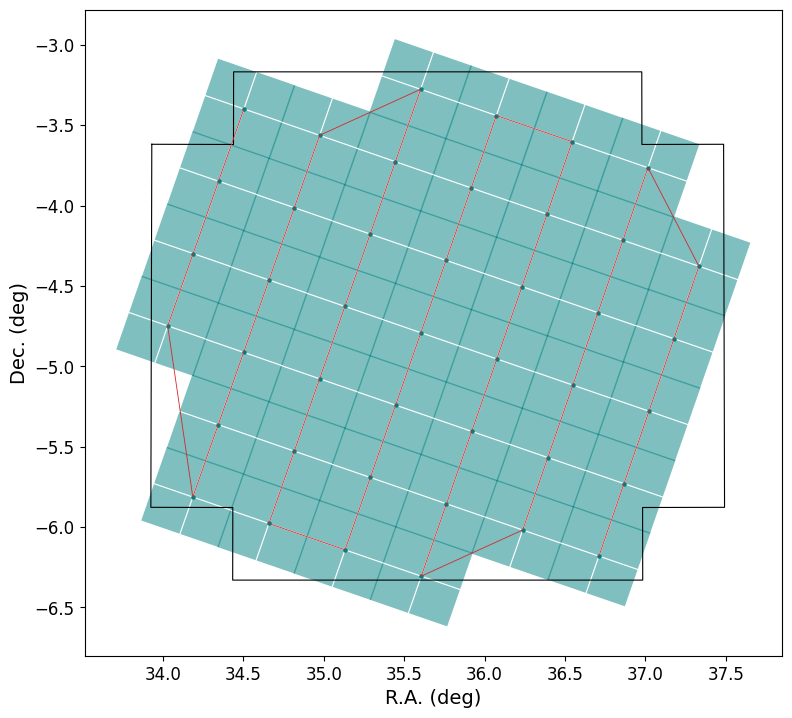

In [8]:
# Visualize the tiles
tiling_result.plot_snake_scan(tile_color='teal', show_sequence=True, show_tile_centers=True)

**Start observation.** 

Call the `observe()` method on the `SmallSurvey` instance to observe the tiles in an optimal sequence. This optimization considers target visibility and minimizes slews. The method monitors power generation, battery usage, and onboard data accumulation throughout the observation process, calculates the survey's observing efficiency, and provides a breakdown of total clock time allocations.

- `obs_results` : A dictionary of the survey's observation results, including the time allocated to each task. 
- `battery_tracker` : A dictionary tracking the onboard battery energy level (in W-hr) at different times throughout the observation. 
- `data_tracker` : A dictionary tracking the amount of data onboard (in GB) at different times throughout the observation.
- `obs_sequence` : A list of tiles represented as `InertialTarget` instances, ordered in the optimal observing sequence.

In [9]:
# Observe the survey 
obs_results, battery_tracker, data_tracker, obs_sequence = CASTOR_cadence_survey.observe(obs_day)

Start observing at 2024-07-27 00:58:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 29.70 %
Total clock time: 05h 28m 46.518s
Total time spent on other surveys: 01h 33m 2.933s
Total time spent on this survey: 03h 55m 43.585s
   Exposure time (29.70 %): 01h 10m 0.000s
   Idle time (0.00 %): 0.000s
   Slew time (24.89 %): 58m 40.225s
code runtime: 23.570s



Let's observe the survey on a more efficient day (i.e., closer to the day when the survey field is in the anti-Sun direction as seen from Earth).

In [16]:
from observation import find_anti_SunRA_day
import parameters as params

# Find the anti-Sun direction observation day
ra_coords = [ra for ra, dec in CASTOR_cadence_survey.boundary_coords]
min_ra, max_ra = min(ra_coords), max(ra_coords)
survey_center = (min_ra + max_ra) / 2
anti_SunRA_day = find_anti_SunRA_day(survey_center, params.VE)
anti_SunRA_day

<Time object: scale='utc' format='iso' value=2024-10-22 00:00:00.000>

In [18]:
# Pick another observation day
another_obs_day = obs_days[100]
another_obs_day

<Time object: scale='utc' format='iso' value=2024-11-04 00:00:00.000>

In [20]:
# Tile the survey field
tiling_result = CASTOR_cadence_survey.tile(another_obs_day)
print(tiling_result)

The tiles are rotated by -9.92° to better align the body-mounted solar arrays with the Sun.
<Tiling object: survey='small', footprint_area=10.51 deg², rotation_angle=-9.92°, num_tiles=44>


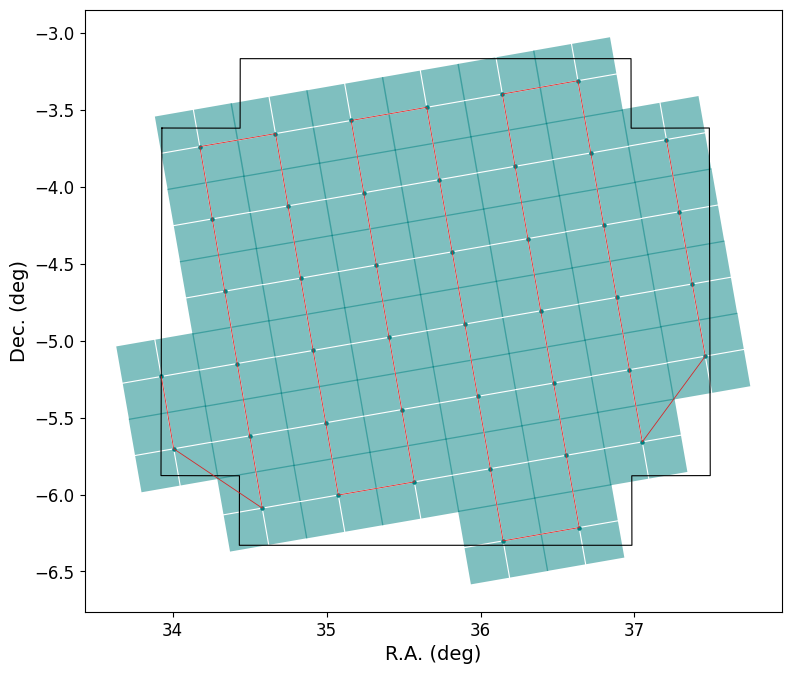

In [21]:
# Visualize the tiles
tiling_result.plot_snake_scan(tile_color='teal', show_sequence=True, show_tile_centers=True)

In [22]:
# Observe the survey 
obs_results, battery_tracker, data_tracker, obs_sequence = CASTOR_cadence_survey.observe(another_obs_day)

Start observing at 2024-11-04 00:00:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 34.52 %
Total clock time: 03h 32m 24.894s
Total time spent on other surveys: 0.000s
Total time spent on this survey: 03h 32m 24.894s
   Exposure time (34.52 %): 01h 13m 20.000s
   Idle time (0.00 %): 0.000s
   Slew time (13.66 %): 29m 1.374s
code runtime: 14.540s



<ins>Note</ins>: As the tile's orientation (rotation angle) changes on different observation days, the number of tiles required to cover the same fraction of the survey field also changes.

**Example: Find the small survey observing efficiency at different exposure times.**
The following evaluates observations on the least and most efficient days, specifically the days when the CVZ center is farthest from and closest to the survey field. Different exposure times are tested to assess how observing efficiency improves with increasing exposure (integration) time per tile.

In [25]:
import numpy as np

# Find the small survey observation results at different integration time (exposure) 
# Exposure times per tile in seconds
step_size = 10
exposures = np.arange(100, 940, step_size)

In [36]:
# Observing on the least efficient day 
# when the telescope's CVZ is furthest from the survey field
least_efficient_day = obs_days[0]

# to store observation results
least_obs_effs = []
least_total_time = []

# Tile the survey 
least_tiling_result = CASTOR_cadence_survey.tile(least_efficient_day)
print(f"Takes {least_tiling_result.num_tiles} tiles to cover the survey field.")
print()

# Observe with different exposure times
for expo in exposures:
    CASTOR_cadence_survey.exposure = expo
    print(f"\033[1mExposure time = {CASTOR_cadence_survey.exposure} s\033[0m")
    least_obs_results, _, _, _ = CASTOR_cadence_survey.observe(least_efficient_day)
    least_obs_effs.append(least_obs_results['obs_efficiency'])
    least_total_time.append(least_obs_results['total_clock_time'])

The tiles are rotated by 109.11° to better align the body-mounted solar arrays with the Sun.
Takes 42 tiles to cover the survey field.

Exposure time = 100 s
Start observing at 2024-07-27 00:58:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 29.70 %
Total clock time: 05h 28m 46.518s
Total time spent on other surveys: 01h 33m 2.933s
Total time spent on this survey: 03h 55m 43.585s
   Exposure time (29.70 %): 01h 10m 0.000s
   Idle time (0.00 %): 0.000s
   Slew time (24.89 %): 58m 40.225s
code runtime: 29.032s

Exposure time = 110 s
Start observing at 2024-07-27 00:58:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 31.40 %
Total clock time: 05h 38m 14.768s
Total time spent on other surveys: 01h 33m 3.000s
Total time spent on this survey: 04h 05m 11.768s
   Exposure time (31.40 %): 01h 17m 0.000s
   Idle time (0.00 %): 0.000s
   Slew time (24.12 %): 59m 8.408s
code runtime: 27.347s

Exposure time = 120 s
Start

In [41]:
# Observing on the most efficient day 
# when the telescope's CVZ is overlapping with the survey field
most_efficient_day = obs_days[100]

# to store observation results
most_obs_effs = []
most_total_time = []

# Tile the survey 
most_tiling_result = CASTOR_cadence_survey.tile(most_efficient_day)
print(f"Takes {most_tiling_result.num_tiles} tiles to cover the survey field.")

# Truncate the survey footprint to the same size as the one on the `least_efficient_day`.
CASTOR_cadence_survey.tile_targets = CASTOR_cadence_survey.tile_targets[:42]
print("Limit the footprint to 42 tiles to match the area observed on the `least_efficient_day`.")
print()

# Observe with different exposure times
for expo in exposures:
    CASTOR_cadence_survey.exposure = expo
    print(f"\033[1mExposure time = {CASTOR_cadence_survey.exposure} s\033[0m")
    most_obs_results, _, _, _ = CASTOR_cadence_survey.observe(most_efficient_day)
    most_obs_effs.append(most_obs_results['obs_efficiency'])
    most_total_time.append(most_obs_results['total_clock_time'])


The tiles are rotated by -9.92° to better align the body-mounted solar arrays with the Sun.
Takes 44 tiles to cover the survey field.
Limit the footprint to 42 tiles to match the area observed on the `least_efficient_day`.

Exposure time = 100 s
Start observing at 2024-11-04 00:00:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 34.50 %
Total clock time: 03h 22m 52.826s
Total time spent on other surveys: 0.000s
Total time spent on this survey: 03h 22m 52.826s
   Exposure time (34.50 %): 01h 10m 0.000s
   Idle time (0.00 %): 0.000s
   Slew time (13.71 %): 27m 49.466s
code runtime: 13.260s

Exposure time = 110 s
Start observing at 2024-11-04 00:00:00.000
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.
Observing efficiency: 36.69 %
Total clock time: 03h 29m 52.826s
Total time spent on other surveys: 0.000s
Total time spent on this survey: 03h 29m 52.826s
   Exposure time (36.69 %): 01h 17m 0.000s
   Idle time (0.00 %): 0.000s
   Slew time 

In [61]:
# Store the results in a dictionary
cadence_survey_expo_results = {}
cadence_survey_expo_results["exposures"] = exposures.tolist()
cadence_survey_expo_results["least_efficient"] = {
    "obs_day": least_efficient_day.strftime('%Y-%m-%d'),
    "obs_effs": least_obs_effs,
    "total_time": least_total_time
}
cadence_survey_expo_results["most_efficient"] = {
    "obs_day": most_efficient_day.strftime('%Y-%m-%d'),
    "obs_effs": most_obs_effs,
    "total_time": most_total_time
}

In [63]:
import json

# Save as JSON file
with open("cadence_survey_expo_results.json", "w") as file:
    json.dump(cadence_survey_expo_results, file, indent=2)

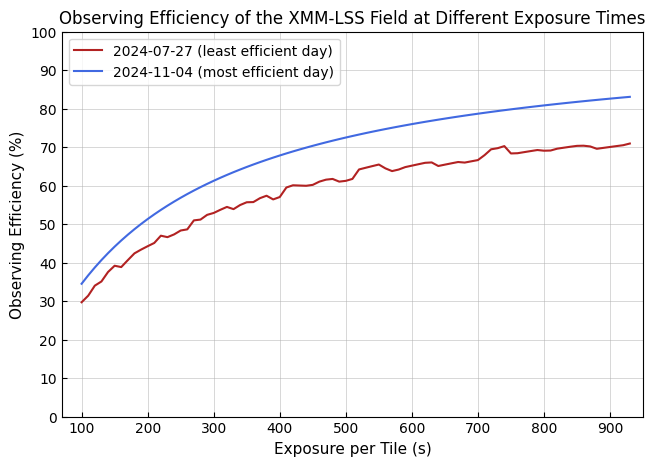

In [67]:
import matplotlib.pyplot as plt

# Plot the results
exposures = cadence_survey_expo_results["exposures"]
least_obs_day = cadence_survey_expo_results["least_efficient"]["obs_day"]
least_obs_eff = cadence_survey_expo_results["least_efficient"]["obs_effs"]
most_obs_day = cadence_survey_expo_results["most_efficient"]["obs_day"]
most_obs_eff = cadence_survey_expo_results["most_efficient"]["obs_effs"]

fig = plt.figure(figsize=(7.5, 5))
plt.plot(exposures, least_obs_eff, label=f"{least_obs_day} (least efficient day)", color='firebrick')
plt.plot(exposures, most_obs_eff, label=f"{most_obs_day} (most efficient day)", color='royalblue')

plt.xlim(70, 950)
plt.ylim(0, 100)
plt.xticks(range(100, 1000, 100))
plt.yticks(range(0, 110, 10))
plt.tick_params(direction='in')

plt.xlabel("Exposure per Tile (s)", fontsize=11)
plt.ylabel("Observing Efficiency (%)", fontsize=11)
plt.title("Observing Efficiency of the XMM-LSS Field at Different Exposure Times")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.7, linewidth=0.5)
# plt.savefig('XMM-LSS (obs_eff vs. exposure).pdf')
plt.show()


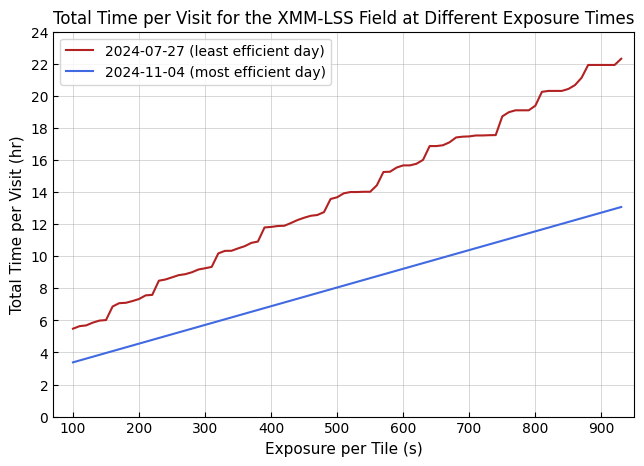

In [70]:
least_total_time = cadence_survey_expo_results["least_efficient"]["total_time"]
most_total_time = cadence_survey_expo_results["most_efficient"]["total_time"]
least_total_time_hr = np.array(least_total_time) / 3600
most_total_time_hr = np.array(most_total_time) / 3600

fig = plt.figure(figsize=(7.5, 5))
plt.plot(exposures, least_total_time_hr, label=f"{least_obs_day} (least efficient day)", color='firebrick')
plt.plot(exposures, most_total_time_hr, label=f"{most_obs_day} (most efficient day)", color='royalblue')

plt.xlim(70, 950)
plt.ylim(0, 24)
plt.xticks(range(100, 1000, 100))
plt.yticks(range(0, 25, 2))
plt.tick_params(direction='in')

plt.xlabel("Exposure per Tile (s)", fontsize=11)
plt.ylabel("Total Time per Visit (hr)", fontsize=11)
plt.title("Total Time per Visit for the XMM-LSS Field at Different Exposure Times")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.7, linewidth=0.5)
# plt.savefig('XMM-LSS (total_time vs. exposure).pdf')
plt.show()


### Implement Wide Surveys
Wide surveys typically cover a large, contiguous areas of around 1000 square degrees or more. Let's use the CASTOR Wide Survey as an example, which aims to cover the Roman HLS field in one observing season.

**Define the survey** by providing the following specifications:
* boundary coordinates: the survey footprint boundaries in (RA, Dec)
* exposure: the duration of the required exposure time in seconds
* downlink frequency: the frequency band selected for data downlink

A single visit of a wide survey typically spans several months of observations. To determine the optimal spacecraft rolls during the observation period, the `tile()` method automatically sets the observation start time to 60 days before the first tile's optimal observation day, which corresponds to when the telescope is pointing in the anti-Sun direction. Users can customize how far in advance the observation begins by adjusting the `num_days_ahead` parameter.

In [71]:
from surveys import WideSurvey
import numpy as np

# Define footprint boundary
wide_footprint = np.loadtxt('Wide_footprint.txt', skiprows=1)

# Define the Wide Survey
CASTOR_wide_survey = WideSurvey(
    satellite=CASTOR, boundary_coords=wide_footprint, exposure=1000, downlink_freq='Ka'
)
CASTOR_wide_survey

<WideSurvey object: exposure=1000 s, downlink_freq='Ka'>

**Tile the survey field.** The `dec_cutoff` parameter allows users to truncate the footprint if the observation cannot be completed within a single observing season.

<ins>Note</ins>: The roll angles are currently only limited to multiples of 90°.

In [72]:
# Tile the survey
tiling_result = CASTOR_wide_survey.tile(dec_cutoff=-48) # can modify the footprint
print(tiling_result)

Tiling the survey field...
code runtime: 01m 0.030s
<Tiling object: survey='wide', footprint_area=2176.76 deg², num_bins=35, num_tiles=9112>


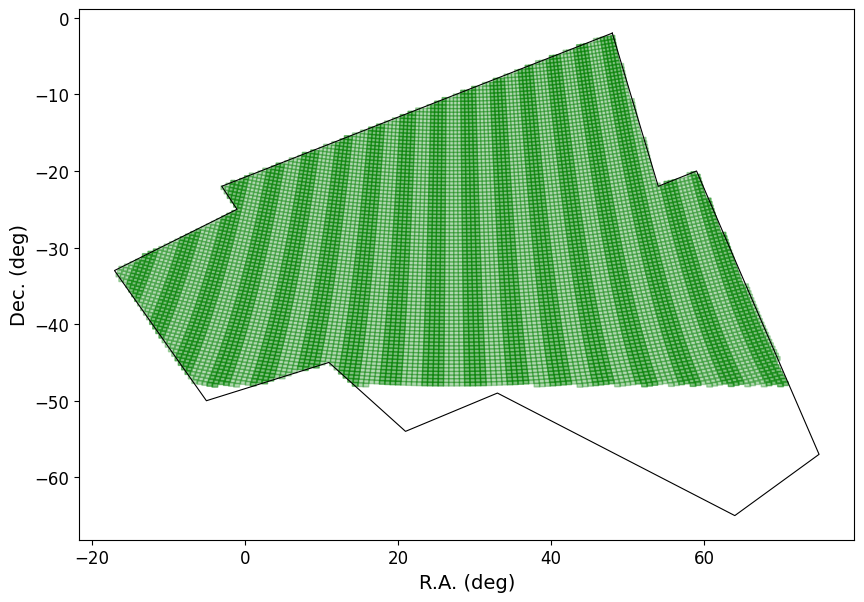

In [73]:
# Visualize the tiles grouped into `bins`
tiling_result.plot_bins(tile_color='green')

**Start observation.** The data downlink frequency band can be adjusted using the `downlink_freq` attribute. The `observe()` method of `WideSurvey` functions similarly to that of `SmallSurvey` described above.

In [74]:
# Observe the survey
wide_obs_results, wide_battery_tracker, wide_ka_band_data_tracker, wide_obs_sequence = CASTOR_wide_survey.observe()

Start observing on 2024-07-05, 60 days ahead of the first tile.
Downlinking in Ka-band at 0.3 GBps with 2 ground stations.

Observing bin1: 14 tiles
bin1 completed
Currently observing around RA = -15.57 deg
Time spent completing this bin: 07h 32m 3.739s
Cumulative observing efficiency: 70.57 %
current time: 2024-07-05 08:01:03.739
current anti-Sun RA day: 2024-09-04 00:00:00.000
Total clock time: 07h 32m 3.739s
code runtime: 32.690s

Observing bin2: 47 tiles
bin2 completed
Currently observing around RA = -11.63 deg
Time spent completing this bin: 1d 02h 40m 51.438s
Cumulative observing efficiency: 70.37 %
current time: 2024-07-06 10:41:55.177
current anti-Sun RA day: 2024-09-07 00:00:00.000
Total clock time: 1d 10h 12m 55.177s
code runtime: 02m 2.595s

Observing bin3: 80 tiles
bin3 completed
Currently observing around RA = -9.51 deg
Time spent completing this bin: 1d 21h 05m 51.416s
Cumulative observing efficiency: 71.94 %
current time: 2024-07-08 07:47:46.593
current anti-Sun RA day: 

In [77]:
import json
import pickle

save_wide_survey_data = False

if save_wide_survey_data:
    # Save `obs_result`
    with open("wide_obs_results.json", "w") as file:
        json.dump(wide_obs_results, file, indent=2)

    # Save `battery_tracker`
    with open("wide_battery_tracker.json", "w") as file:
        json.dump(wide_battery_tracker, file, indent=2)
    
    # Save `data_tracker`
    with open("wide_ka_band_data_tracker.json", "w") as file:
        json.dump(wide_ka_band_data_tracker, file, indent=2)
    
    # Save `obs_sequence`, the list of observed Target objects
    with open("wide_obs_sequence.pkl", "wb") as file:
        pickle.dump(wide_obs_sequence, file)